In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold, LeaveOneGroupOut, StratifiedKFold
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
from sklearn.preprocessing import StandardScaler

In [2]:
inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_04_26_hls_idxs_manual_combine.csv'

inPATH = os.path.join(inDIR, inFILE)

outDIR = './results/'

var_names = ['dfi', 'ndvi', 'ndti', 'satvi', 'ndii7', 'nir', 'swir1', 'swir2',
             'bai_126', 'bai_136', 'bai_146', 'bai_236', 'bai_246', 'bai_346']

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

xv_vars = ['dfi', 'ndti', 'satvi', 'ndii7', 'swir1', 'swir2']
nsplits = 10

rand_st = 2313

In [3]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [4]:
df_vor = pd.read_csv(inPATH, parse_dates=[2, 3])
df_vor = df_vor.rename(columns=var_dict)

In [5]:
df_vor = df_vor[df_vor['Season'].isin(['June', 'October'])].copy()
#df_vor = df_vor[df_vor['Year'] <= 2020].copy()

In [6]:
X_vars_all = df_vor[var_names]
Y_var_all = df_vor['Biomass_kg_ha']

In [7]:
# check for any missing data
len(df_vor[df_vor[var_names].isnull().any(axis=1)])

0

In [8]:
# remove missing data
df_vor = df_vor[~df_vor[var_names].isnull().any(axis=1)].copy()

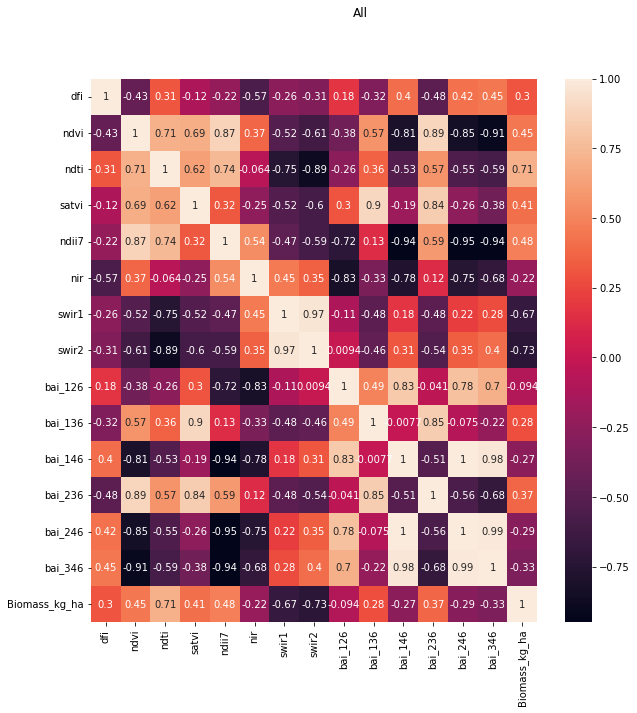

In [9]:
corrMatrix = X_vars_all.reset_index(drop=True).join(Y_var_all.reset_index(drop=True)).corr()
plt.figure(figsize=(10, 10))
plt.suptitle('All')
sns.heatmap(corrMatrix, annot=True)
plt.show()

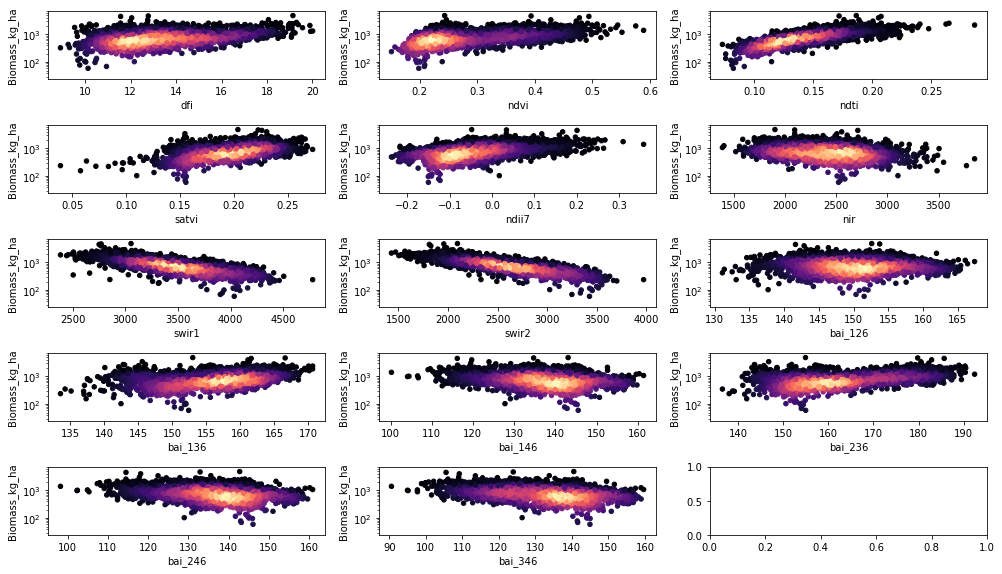

In [10]:
fig, axs = plt.subplots(figsize=(14, 8),
                        nrows=int(np.ceil(len(var_names) / 3)), ncols=3)
for idx, v in enumerate(var_names):
    xy_bm = np.vstack([df_vor[v], df_vor['Biomass_kg_ha']])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    df_vor.plot.scatter(x=v, y='Biomass_kg_ha', logy=True, ax=axs.flatten()[idx], ylim=(25, 7000),
                            c=z_bm, cmap='magma', colorbar=False)
    plt.tight_layout(pad=1.0)

In [12]:
df_vor['Year'].unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [13]:
df_vor[df_vor['swir1'] > 4600]

,Id,Pasture,Date,Date_mean,Year,Season,Low,High,Biomass_kg_ha,geometry,...,ndii7,bai_126,bai_136,bai_146,bai_236,bai_246,bai_346,nir,swir1,swir2
2942,5W_P2,5W,2022-06-02,2022-06-02,2022,June,0.77,4.33,238,"POLYGON ((526037.7265014648 4522825.522277832,...",...,-0.025909,133.090494,133.604513,128.737066,137.979482,131.509664,132.680651,3772.856726,4777.020148,3972.102408


In [14]:
X_vars_all = df_vor[[x for x in var_names if x not in ['bai_246', 'bai_346']]]

log_xfrm = True
wtd = False
poly = False
scale_vars = False
mod_logo = LeaveOneGroupOut()
scaler = StandardScaler(with_mean=True, with_std=False)

In [15]:
df_results = pd.DataFrame(columns=['model', 'numb_vars', 'formula', 'xv',
                                   'R2', 'R2_adj', 'AIC', 'rmse_kg_mean', 'rmse_kg_sd', 'mpe',
                                   'rmse_pct_mean', 'rmse_pct_sd', 'rmse_pct_max',
                                   'mae_kg_mean', 'mae_kg_sd', 'mae_orig_mean', 'mae_orig_sd',
                                   'rmse_orig_mean', 'rmse_orig_sd', 'rmse_orig_pct_mean', 'rmse_orig_pct_sd',
                                   'rmse_kg_low_mean', 'rmse_pct_low_mean', 'mpe_low'])
df_results_full = pd.DataFrame(columns=['model', 'kfold', 'numb_vars', 'formula', 'xv',
                                        'R2', 'R2_adj', 'AIC', 'rmse_kg', 'pe',
                                        'rmse_pct',  'rmse_orig',  'rmse_orig_pct',
                                        'rmse_kg_low', 'rmse_pct_low', 'pe_low'])

In [16]:
for k in tqdm(range(1, 6 + 1)):
    for combo in itertools.combinations(var_names, k):
        combo_corr = df_vor[np.array(combo)].corr()
        if ((combo_corr != 1.0) & (combo_corr.abs() > 0.8)).any(axis=None):
            continue
        else:
            if k == 1:
                if log_xfrm:
                    lr_form_simp = 'np.log(Biomass_kg_ha) ~ ' + combo[0]
                else:
                    lr_form_simp = 'Biomass_kg_ha ~ ' + combo[0]
                if poly:
                    lr_form_simp = lr_form_simp + ' + I(' + combo[0] + '**2)'
                form_dict = dict(simp=lr_form_simp)
            if k > 1:
                if log_xfrm:
                    lr_form_simp = 'np.log(Biomass_kg_ha) ~ ' + combo[0]
                else:
                    lr_form_simp = 'Biomass_kg_ha ~ ' + combo[0]
                for c in combo[1:]:
                    lr_form_simp = lr_form_simp + ' + ' + c
                for combo_c in itertools.combinations(combo, 2):
                    lr_form_simp = lr_form_simp + ' + ' + combo_c[0] + ':' + combo_c[1]
                if poly:
                    for c in combo:
                        lr_form_simp = lr_form_simp + ' + I(' + c + '**2)'
                form_dict = dict(simp=lr_form_simp)
            for f in form_dict:
                years_tmp = []
                r2_tmp = []
                r2_adj_tmp = []
                aic_tmp = []
                rmse_kg_tmp = []
                mae_kg_tmp = []
                mpe_tmp = []
                rmse_kg_low_tmp = []
                mean_kg_low_tmp = []
                mpe_low_tmp = []
                rmse_orig_tmp = []
                mae_orig_tmp = []
                for train_index, test_index in mod_logo.split(df_vor, groups=df_vor['Date'].dt.year):
                    df_train = df_vor.iloc[train_index]
                    df_test = df_vor.iloc[test_index]
                    if scale_vars:
                        scaler.fit(df_train[var_names])
                        df_train.loc[:, var_names] = scaler.transform(df_train[var_names])
                        df_test.loc[:, var_names] = scaler.transform(df_test[var_names])
                    if wtd:
                        lreg_k_tmp = smf.wls(formula=form_dict[f], data=df_train,
                                             weights=1 / df_train['Biomass_kg_ha']).fit()
                    else:
                        lreg_k_tmp = smf.ols(formula=form_dict[f], data=df_train).fit()
                    years_tmp.append(df_test['Date'].dt.year.unique()[0])
                    r2_tmp.append(lreg_k_tmp.rsquared)
                    r2_adj_tmp.append(lreg_k_tmp.rsquared_adj)
                    aic_tmp.append(lreg_k_tmp.aic)
                    if log_xfrm:
                        see_k_tmp = np.sqrt(np.sum((np.log(df_vor['Biomass_kg_ha'].iloc[train_index]) -
                                                    lreg_k_tmp.predict(df_vor.iloc[train_index])) ** 2) /
                                            (len(train_index) - len(lreg_k_tmp.params)))
                        cf_k_tmp = np.exp(see_k_tmp ** 2 / 2)  # correction factor from Sprugel 1983
                        pred_tmp = np.exp(lreg_k_tmp.predict(df_test))  # * cf_k_tmp
                        rmse_orig_tmp.append(np.sqrt(np.nanmean((lreg_k_tmp.predict(df_test) -
                                                                 np.log(df_test['Biomass_kg_ha'])) ** 2)))
                        mae_orig_tmp.append(np.nanmean(np.abs(lreg_k_tmp.predict(df_test) - np.log(df_test['Biomass_kg_ha']))))
                    else:
                        pred_tmp = lreg_k_tmp.predict(df_test)
                        rmse_orig_tmp.append(np.nan)
                        rmse_orig_pct_tmp = np.nan
                        mae_orig_tmp.append(np.nan)
                    low_idx = df_test['Biomass_kg_ha'] < 700
                    rmse_kg_tmp.append(np.sqrt(np.nanmean((pred_tmp - df_test['Biomass_kg_ha']) ** 2)))
                    mae_kg_tmp.append(np.nanmean(np.abs(np.exp(lreg_k_tmp.predict(df_test)) - df_test['Biomass_kg_ha'])))
                    mpe_tmp.append(np.nanmean((pred_tmp - df_test['Biomass_kg_ha']) / df_test['Biomass_kg_ha']))
                    rmse_kg_low_tmp.append(
                        np.sqrt(np.nanmean((pred_tmp[low_idx] - df_test['Biomass_kg_ha'][low_idx]) ** 2)))
                    mean_kg_low_tmp.append(df_test['Biomass_kg_ha'][low_idx].mean())
                    mpe_low_tmp.append(np.nanmean((pred_tmp[low_idx] - df_test['Biomass_kg_ha'][low_idx]) /
                                                  df_test['Biomass_kg_ha'][low_idx]))
                rmse_pct_tmp = np.array(rmse_kg_tmp) / df_vor.groupby('Year')['Biomass_kg_ha'].mean()
                rmse_orig_pct_tmp = np.array(rmse_orig_tmp) / \
                                    df_vor.groupby('Year')['Biomass_kg_ha'].apply(lambda x: np.log(x).mean())
                rmse_pct_low_tmp = np.array(rmse_kg_low_tmp) / np.array(mean_kg_low_tmp)
                mae_pct_tmp = np.array(mae_kg_tmp) / df_vor.groupby('Year')['Biomass_kg_ha'].mean()
                if wtd:
                    lreg_all_tmp = smf.wls(formula=form_dict[f], data=df_vor,
                                           weights=1 / df_vor['Biomass_kg_ha']).fit()
                else:
                    lreg_all_tmp = smf.ols(formula=form_dict[f], data=df_vor).fit()
                df_results_tmp = pd.DataFrame(dict(model='Temporal',
                                                   numb_vars=[k],
                                                   formula=[form_dict[f]],
                                                   xv=[f],
                                                   R2=round(lreg_all_tmp.rsquared, 4),
                                                   R2_adj=round(lreg_all_tmp.rsquared_adj, 4),
                                                   AIC=round(lreg_all_tmp.aic, 4),
                                                   rmse_kg_mean=round(np.mean(rmse_kg_tmp), 4),
                                                   rmse_kg_sd=round(np.std(rmse_kg_tmp), 4),
                                                   mae_kg_mean=round(np.mean(mae_kg_tmp), 4),
                                                   mae_kg_sd=round(np.std(mae_kg_tmp), 4),
                                                   mae_kg_max=round(np.max(mae_kg_tmp), 4),
                                                   mpe=round(np.mean(mpe_tmp), 4),
                                                   rmse_pct_mean=round(np.mean(rmse_pct_tmp), 4),
                                                   rmse_pct_sd=round(np.std(rmse_pct_tmp), 4),
                                                   rmse_pct_max=round(np.max(rmse_pct_tmp), 4),
                                                   rmse_orig_mean=round(np.mean(rmse_orig_tmp), 4),
                                                   rmse_orig_sd=round(np.std(rmse_orig_tmp), 4),
                                                   rmse_orig_pct_mean=round(np.mean(rmse_orig_pct_tmp), 4),
                                                   rmse_orig_pct_sd=round(np.std(rmse_orig_pct_tmp), 4),
                                                   mae_orig_mean=round(np.mean(mae_orig_tmp), 4),
                                                   mae_orig_sd=round(np.std(mae_orig_tmp), 4),
                                                   mae_pct_mean=round(np.mean(mae_pct_tmp), 4),
                                                   mae_pct_sd=round(np.std(mae_pct_tmp), 4),
                                                   mae_pct_max=round(np.max(mae_pct_tmp), 4),
                                                   rmse_kg_low_mean=round(np.mean(rmse_kg_low_tmp), 4),
                                                   rmse_pct_low_mean=round(np.mean(rmse_pct_low_tmp), 4),
                                                   mpe_low=round(np.mean(mpe_low_tmp), 4)))
                df_results_full_tmp = pd.DataFrame(dict(model='Temporal',
                                                        kfold=years_tmp,
                                                        numb_vars=np.repeat(k, len(r2_tmp)),
                                                        formula=np.repeat(form_dict[f], len(r2_tmp)),
                                                        xv=np.repeat(f, len(r2_tmp)),
                                                        R2=np.round(r2_tmp, 4),
                                                        R2_adj=np.round(r2_adj_tmp, 4),
                                                        AIC=np.round(aic_tmp, 4),
                                                        rmse_kg=np.round(rmse_kg_tmp, 4),
                                                        mae_kg=np.round(mae_kg_tmp, 4),
                                                        pe=np.round(mpe_tmp, 4),
                                                        rmse_pct=round(rmse_pct_tmp, 4),
                                                        rmse_orig=np.round(rmse_orig_tmp, 4),
                                                        mae_pct=np.round(mae_pct_tmp, 4),
                                                        mae_orig=np.round(mae_orig_tmp, 4),
                                                        rmse_orig_pct=round(rmse_orig_pct_tmp, 4),
                                                        rmse_kg_low=np.round(rmse_kg_low_tmp, 4),
                                                        rmse_pct_low=np.round(rmse_pct_low_tmp, 4),
                                                        pe_low=np.round(mpe_low_tmp, 4)))
                df_results = pd.concat([df_results, df_results_tmp])
                df_results_full = pd.concat([df_results_full, df_results_full_tmp.reset_index(drop=True)])

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:26<00:00, 34.42s/it]


In [17]:
df_results['index'] = np.arange(len(df_results))
df_results = df_results.set_index('index')

In [18]:
mod_kstrat = GroupKFold(n_splits=len(df_vor.Year.unique()))

for k in tqdm(range(1, 6 + 1)):
    for combo in itertools.combinations(var_names, k):
        combo_corr = df_vor[np.array(combo)].corr()
        if ((combo_corr != 1.0) & (combo_corr.abs() > 0.8)).any(axis=None):
            continue
        else:
            if k == 1:
                if log_xfrm:
                    lr_form_simp = 'np.log(Biomass_kg_ha) ~ ' + combo[0]
                else:
                    lr_form_simp = 'Biomass_kg_ha ~ ' + combo[0]
                if poly:
                    lr_form_simp = lr_form_simp + ' + I(' + combo[0] + '**2)'
                form_dict = dict(simp=lr_form_simp)
            if k > 1:
                if log_xfrm:
                    lr_form_simp = 'np.log(Biomass_kg_ha) ~ ' + combo[0]
                else:
                    lr_form_simp = 'Biomass_kg_ha ~ ' + combo[0]
                for c in combo[1:]:
                    lr_form_simp = lr_form_simp + ' + ' + c
                for combo_c in itertools.combinations(combo, 2):
                    lr_form_simp = lr_form_simp + ' + ' + combo_c[0] + ':' + combo_c[1]
                if poly:
                    for c in combo:
                        lr_form_simp = lr_form_simp + ' + I(' + c + '**2)'
                form_dict = dict(simp=lr_form_simp)
            for f in form_dict:
                r2_tmp = []
                r2_adj_tmp = []
                aic_tmp = []
                rmse_kg_tmp = []
                mae_kg_tmp = []
                mpe_tmp = []
                rmse_kg_low_tmp = []
                mean_kg_low_tmp = []
                mpe_low_tmp = []
                rmse_orig_tmp = []
                mae_orig_tmp = []
                for train_index, test_index in mod_kstrat.split(X=df_vor, groups=df_vor['Pasture']):
                    df_train = df_vor.iloc[train_index]
                    df_test = df_vor.iloc[test_index]
                    if scale_vars:
                        scaler.fit(df_train[var_names])
                        df_train.loc[:, var_names] = scaler.transform(df_train[var_names])
                        df_test.loc[:, var_names] = scaler.transform(df_test[var_names])
                    if wtd:
                        lreg_k_tmp = smf.wls(formula=form_dict[f], data=df_train,
                                             weights=1 / df_train['Biomass_kg_ha']).fit()
                    else:
                        lreg_k_tmp = smf.ols(formula=form_dict[f], data=df_train).fit()
                    r2_tmp.append(lreg_k_tmp.rsquared)
                    r2_adj_tmp.append(lreg_k_tmp.rsquared_adj)
                    aic_tmp.append(lreg_k_tmp.aic)
                    if log_xfrm:
                        see_k_tmp = np.sqrt(np.sum((np.log(df_vor['Biomass_kg_ha'].iloc[train_index]) -
                                                    lreg_k_tmp.predict(df_vor.iloc[train_index])) ** 2) /
                                            (len(train_index) - len(lreg_k_tmp.params)))
                        cf_k_tmp = np.exp(see_k_tmp ** 2 / 2)  # correction factor from Sprugel 1983
                        pred_tmp = np.exp(lreg_k_tmp.predict(df_test))  # * cf_k_tmp
                        rmse_orig_tmp.append(np.sqrt(np.nanmean((lreg_k_tmp.predict(df_test) -
                                                                 np.log(df_test['Biomass_kg_ha'])) ** 2)))
                        mae_orig_tmp.append(np.nanmean(np.abs(lreg_k_tmp.predict(df_test) - np.log(df_test['Biomass_kg_ha']))))
                    else:
                        pred_tmp = lreg_k_tmp.predict(df_test)
                        rmse_orig_tmp.append(np.nan)
                        rmse_orig_pct_tmp = np.nan
                        mae_orig_tmp.append(np.nan)
                    low_idx = df_test['Biomass_kg_ha'] < 700
                    rmse_kg_tmp.append(np.sqrt(np.nanmean((pred_tmp - df_test['Biomass_kg_ha']) ** 2)))
                    mae_kg_tmp.append(np.nanmean(np.abs(np.exp(lreg_k_tmp.predict(df_test)) - df_test['Biomass_kg_ha'])))
                    mpe_tmp.append(np.nanmean((pred_tmp - df_test['Biomass_kg_ha']) / df_test['Biomass_kg_ha']))
                    rmse_kg_low_tmp.append(
                        np.sqrt(np.nanmean((pred_tmp[low_idx] - df_test['Biomass_kg_ha'][low_idx]) ** 2)))
                    mean_kg_low_tmp.append(df_test['Biomass_kg_ha'][low_idx].mean())
                    mpe_low_tmp.append(np.nanmean((pred_tmp[low_idx] - df_test['Biomass_kg_ha'][low_idx]) /
                                                  df_test['Biomass_kg_ha'][low_idx]))
                rmse_pct_tmp = np.array(rmse_kg_tmp) / df_vor.groupby('Year')['Biomass_kg_ha'].mean()
                rmse_orig_pct_tmp = np.array(rmse_orig_tmp) / \
                                    df_vor.groupby('Year')['Biomass_kg_ha'].apply(lambda x: np.log(x).mean())
                rmse_pct_low_tmp = np.array(rmse_kg_low_tmp) / np.array(mean_kg_low_tmp)
                mae_pct_tmp = np.array(mae_kg_tmp) / df_vor.groupby('Year')['Biomass_kg_ha'].mean()
                if wtd:
                    lreg_all_tmp = smf.wls(formula=form_dict[f], data=df_vor,
                                           weights=1 / df_vor['Biomass_kg_ha']).fit()
                else:
                    lreg_all_tmp = smf.ols(formula=form_dict[f], data=df_vor).fit()
                df_results_tmp = pd.DataFrame(dict(model='Spatial',
                                                   numb_vars=[k],
                                                   formula=[form_dict[f]],
                                                   xv=[f],
                                                   R2=round(lreg_all_tmp.rsquared, 4),
                                                   R2_adj=round(lreg_all_tmp.rsquared_adj, 4),
                                                   AIC=round(lreg_all_tmp.aic, 4),
                                                   rmse_kg_mean=round(np.mean(rmse_kg_tmp), 4),
                                                   rmse_kg_sd=round(np.std(rmse_kg_tmp), 4),
                                                   mae_kg_mean=round(np.mean(mae_kg_tmp), 4),
                                                   mae_kg_sd=round(np.std(mae_kg_tmp), 4),
                                                   mae_kg_max=round(np.max(mae_kg_tmp), 4),
                                                   mpe=round(np.mean(mpe_tmp), 4),
                                                   rmse_pct_mean=round(np.mean(rmse_pct_tmp), 4),
                                                   rmse_pct_sd=round(np.std(rmse_pct_tmp), 4),
                                                   rmse_pct_max=round(np.max(rmse_pct_tmp), 4),
                                                   rmse_orig_mean=round(np.mean(rmse_orig_tmp), 4),
                                                   rmse_orig_sd=round(np.std(rmse_orig_tmp), 4),
                                                   rmse_orig_pct_mean=round(np.mean(rmse_orig_pct_tmp), 4),
                                                   rmse_orig_pct_sd=round(np.std(rmse_orig_pct_tmp), 4),
                                                   mae_orig_mean=round(np.mean(mae_orig_tmp), 4),
                                                   mae_orig_sd=round(np.std(mae_orig_tmp), 4),
                                                   mae_pct_mean=round(np.mean(mae_pct_tmp), 4),
                                                   mae_pct_sd=round(np.std(mae_pct_tmp), 4),
                                                   mae_pct_max=round(np.max(mae_pct_tmp), 4),
                                                   rmse_kg_low_mean=round(np.mean(rmse_kg_low_tmp), 4),
                                                   rmse_pct_low_mean=round(np.mean(rmse_pct_low_tmp), 4),
                                                   mpe_low=round(np.mean(mpe_low_tmp), 4)))
                df_results_full_tmp = pd.DataFrame(dict(model='Spatial',
                                                        kfold=np.arange(1, len(df_vor.Year.unique())+1),
                                                        numb_vars=np.repeat(k, len(r2_tmp)),
                                                        formula=np.repeat(form_dict[f], len(r2_tmp)),
                                                        xv=np.repeat(f, len(r2_tmp)),
                                                        R2=np.round(r2_tmp, 4),
                                                        R2_adj=np.round(r2_adj_tmp, 4),
                                                        AIC=np.round(aic_tmp, 4),
                                                        rmse_kg=np.round(rmse_kg_tmp, 4),
                                                        mae_kg=np.round(mae_kg_tmp, 4),
                                                        pe=np.round(mpe_tmp, 4),
                                                        rmse_pct=round(rmse_pct_tmp, 4),
                                                        rmse_orig=np.round(rmse_orig_tmp, 4),
                                                        mae_pct=round(mae_pct_tmp, 4),
                                                        mae_orig=np.round(mae_orig_tmp, 4),
                                                        rmse_orig_pct=round(rmse_orig_pct_tmp, 4),
                                                        rmse_kg_low=np.round(rmse_kg_low_tmp, 4),
                                                        rmse_pct_low=np.round(rmse_pct_low_tmp, 4),
                                                        pe_low=np.round(mpe_low_tmp, 4)))
                df_results = pd.concat([df_results, df_results_tmp])
                df_results_full = pd.concat([df_results_full, df_results_full_tmp.reset_index(drop=True)])



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:42<00:00, 37.03s/it]


In [19]:
df_results['index'] = np.arange(len(df_results))
df_results = df_results.set_index('index')

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_results[df_results['model'] == 'Temporal'].sort_values('mae_orig_mean', ascending=True).head(10))
    print(df_results[df_results['model'] == 'Spatial'].sort_values('mae_orig_mean', ascending=True).head(10))

          model numb_vars                                            formula  \
index                                                                          
413    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + nir + b...   
417    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + swir1 +...   
392    Temporal         4  np.log(Biomass_kg_ha) ~ ndvi + ndti + satvi + ...   
415    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + swir1 +...   
416    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + swir1 +...   
149    Temporal         3  np.log(Biomass_kg_ha) ~ ndvi + ndti + swir1 + ...   
607    Temporal         5  np.log(Biomass_kg_ha) ~ ndti + satvi + nir + s...   
410    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + nir + s...   
407    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + ndii7 +...   
124    Temporal         3  np.log(Biomass_kg_ha) ~ dfi + nir + bai_346 + ...   

         xv      R2  R2_adj        AIC 

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_results[(df_results['model'] == 'Temporal') &
                     (df_results['numb_vars'] == 4)].sort_values('mae_orig_mean', ascending=True).head(10))
    print(df_results[(df_results['model'] == 'Spatial') &
                     (df_results['numb_vars'] == 4)].sort_values('mae_orig_mean', ascending=True).head(10))

          model numb_vars                                            formula  \
index                                                                          
413    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + nir + b...   
417    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + swir1 +...   
392    Temporal         4  np.log(Biomass_kg_ha) ~ ndvi + ndti + satvi + ...   
415    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + swir1 +...   
416    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + swir1 +...   
410    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + nir + s...   
407    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + satvi + ndii7 +...   
445    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + swir1 + bai_136...   
443    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + swir1 + bai_136...   
444    Temporal         4  np.log(Biomass_kg_ha) ~ ndti + swir1 + bai_136...   

         xv      R2  R2_adj        AIC 

In [26]:
df_results.to_csv(os.path.join(outDIR, "VOR_lreg_results.csv"))
df_results_full.to_csv(os.path.join(outDIR, "VOR_lreg_results_full.csv"))

In [27]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
lr_form = df_results['formula'][413]

df_vor['bm_pred_rf_yr'] = np.nan
df_vor['bm_pred_rft_yr'] = np.nan
df_vor['bm_pred_lr_yr'] = np.nan
df_vor['bm_pred_mlp_yr'] = np.nan

var_names_simp = list(X_vars_all.columns)

scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
mod_skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rand_st)
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error'}
param_grid = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': [2, 4, 6, len(var_names_simp)],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 1000]
}

simp = True
log_xfrm = True
wtd = False
smap_xv = False
tune_rf = True
scale_vars = True
fit_mlp = True
mae_all_full_ktests = []
mae_all_full_lr_ktests = []
mae_tuned_ktests = []
mae_mlp_ktests = []
for train_index, test_index in mod_logo.split(X_vars_all, groups=df_vor['Date'].dt.year):
    print("Running K-fold = " + str(df_vor['Date'].dt.year.iloc[test_index].unique()))
    rf_all_tmp = RandomForestRegressor(n_estimators=500, random_state=rand_st)
    if wtd:
        lreg_tmp = smf.wls(formula=lr_form,
                           data=df_vor.iloc[train_index], weights=1 / df_vor.Biomass_kg_ha.iloc[train_index]).fit()
    else:
        lreg_tmp = smf.ols(formula=lr_form,
                           data=df_vor.iloc[train_index]).fit()
    if log_xfrm:
        see_tmp = np.sqrt(np.sum((np.log(df_vor['Biomass_kg_ha'].iloc[train_index]) -
                                  lreg_tmp.predict(df_vor.iloc[train_index])) ** 2) /
                          (len(train_index) - len(lreg_tmp.params)))
        cf_tmp = np.exp(see_tmp ** 2 / 2)  # correction factor from Sprugel 1983
        predictions_all_lr_tmp = np.exp(lreg_tmp.predict(df_vor.iloc[test_index]))  # * cf_tmp
    else:
        predictions_all_lr_tmp = lreg_tmp.predict(df_vor.iloc[test_index])
    if simp:
        all_X = df_vor[var_names_simp].iloc[test_index, :]
        all_x = df_vor[var_names_simp].iloc[train_index, :]
        scaler.fit(all_x)
    else:
        all_X = df_vor[var_names + xv_names].iloc[test_index, :]
        all_x = df_vor[var_names + xv_names].iloc[train_index, :]
        scaler.fit(all_x)
    if scale_vars:
        all_x = scaler.transform(all_x)
        all_X = scaler.transform(all_X)
    all_y = Y_var_all.iloc[train_index]
    rf_all_tmp.fit(all_x, all_y)

    all_Y = Y_var_all.iloc[test_index]
    predictions_all_tmp = rf_all_tmp.predict(all_X)
    mae_all_full_ktests.append(round(np.mean(np.abs(predictions_all_tmp - all_Y)), 2))
    mae_all_full_lr_ktests.append(round(np.mean(np.abs(predictions_all_lr_tmp - all_Y)), 2))
    
    df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
    df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
    
    if tune_rf:
        #rf_cv_all = mod_skf.split(all_x, df_vor['Year'].iloc[train_index])
        rf_cv_all = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])

        # Create a base model
        rf_all_m1 = RandomForestRegressor(random_state=rand_st)
        # Instantiate the grid search model
        grid_search_all_m1 = GridSearchCV(estimator=rf_all_m1,
                                          param_grid=param_grid,
                                          scoring=scoring, 
                                          refit='MAPE', 
                                          return_train_score=True,
                                          cv=rf_cv_all, 
                                          n_jobs=-1, 
                                          verbose=0)
        grid_search_all_m1.fit(all_x, all_y)
        params_all_m1 = grid_search_all_m1.best_params_
        rf_all_m2 = RandomForestRegressor(n_estimators=params_all_m1['n_estimators'],
                                          min_samples_split=params_all_m1['min_samples_split'],
                                          min_samples_leaf=params_all_m1['min_samples_leaf'],
                                          max_features=params_all_m1['max_features'],
                                          bootstrap=params_all_m1['bootstrap'],
                                          max_depth=params_all_m1['max_depth'],
                                          random_state=rand_st)
        rf_all_m2.fit(all_x, all_y)
        # Use the forest's predict method on the test data
        predictions_all_tmp_m2 = rf_all_m2.predict(all_X)
        mae_tuned_ktests.append(round(np.mean(np.abs(predictions_all_tmp_m2 - all_Y)), 2))
        df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_tmp_m2
    if fit_mlp:
        mlp_all = GradientBoostingRegressor(loss='absolute_error',
                                            n_estimators=500,
                                            random_state=rand_st,
                                            max_depth=3)
        mlp_all.fit(all_x, all_y)
        predictions_all_tmp_mlp = mlp_all.predict(all_X)
        mae_mlp_ktests.append(round(np.mean(np.abs(predictions_all_tmp_mlp - all_Y)), 2))
        df_vor['bm_pred_mlp_yr'].iloc[test_index] = predictions_all_tmp_mlp

print("Original RF model MAE: " + str(np.round(np.mean(mae_all_full_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_all_full_ktests), 2)) + ") kg/ha")
print("Precent RMSE original RF model: ")
print(np.array(mae_all_full_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

if tune_rf:
    print("Tuned RF model MAE: " + str(np.round(np.mean(mae_tuned_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_tuned_ktests), 2)) + ") kg/ha")
    print("Precent RMSE original RF model: ")
    print(np.array(mae_tuned_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

print("Original LR model MAE: " + str(np.round(np.mean(mae_all_full_lr_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_all_full_lr_ktests), 2)) + ") kg/ha")
print("Precent RMSE original LR model: ")
print(np.array(mae_all_full_lr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

print("MLP model MAE: " + str(np.round(np.mean(mae_mlp_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_mlp_ktests), 2)) + ") kg/ha")
print("Precent RMSE original LR model: ")
print(np.array(mae_mlp_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

Running K-fold = [2013]


/tmp/ipykernel_8115/799469119.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_8115/799469119.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_8115/799469119.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_

Running K-fold = [2014]


/tmp/ipykernel_8115/799469119.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_8115/799469119.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_8115/799469119.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_

Running K-fold = [2015]


/tmp/ipykernel_8115/799469119.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_8115/799469119.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_8115/799469119.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_

Running K-fold = [2016]


/tmp/ipykernel_8115/799469119.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_8115/799469119.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_8115/799469119.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_

Running K-fold = [2017]


/tmp/ipykernel_8115/799469119.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_8115/799469119.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_8115/799469119.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_

Running K-fold = [2018]


/tmp/ipykernel_8115/799469119.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_8115/799469119.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_8115/799469119.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_

Running K-fold = [2019]


/tmp/ipykernel_8115/799469119.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_8115/799469119.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_8115/799469119.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_

Running K-fold = [2020]


/tmp/ipykernel_8115/799469119.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_8115/799469119.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_8115/799469119.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_

Running K-fold = [2021]


/tmp/ipykernel_8115/799469119.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_8115/799469119.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_8115/799469119.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_

Running K-fold = [2022]


/tmp/ipykernel_8115/799469119.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_8115/799469119.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_8115/799469119.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_

Original RF model MAE: 251.02 (sd = 121.9) kg/ha
Precent RMSE original RF model: 
Date
2013    0.338919
2014    0.261212
2015    0.490006
2016    0.229133
2017    0.201111
2018    0.225789
2019    0.185816
2020    0.248725
2021    0.261329
2022    0.310831
Name: Biomass_kg_ha, dtype: float64
Tuned RF model MAE: 240.23 (sd = 106.51) kg/ha
Precent RMSE original RF model: 
Date
2013    0.336899
2014    0.274699
2015    0.424400
2016    0.220226
2017    0.191051
2018    0.217258
2019    0.174448
2020    0.233131
2021    0.264117
2022    0.302120
Name: Biomass_kg_ha, dtype: float64
Original LR model MAE: 218.92 (sd = 72.41) kg/ha
Precent RMSE original LR model: 
Date
2013    0.320861
2014    0.257389
2015    0.296891
2016    0.201494
2017    0.199580
2018    0.217092
2019    0.176804
2020    0.210286
2021    0.260367
2022    0.294830
Name: Biomass_kg_ha, dtype: float64
MLP model MAE: 237.73 (sd = 87.54) kg/ha
Precent RMSE original LR model: 
Date
2013    0.336827
2014    0.272312
2015    0.

/tmp/ipykernel_8115/799469119.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_mlp_yr'].iloc[test_index] = predictions_all_tmp_mlp


In [29]:
from pylab import *

cmap = cm.get_cmap('tab20')    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

#1f77b4
#aec7e8
#ff7f0e
#ffbb78
#2ca02c
#98df8a
#d62728
#ff9896
#9467bd
#c5b0d5
#8c564b
#c49c94
#e377c2
#f7b6d2
#7f7f7f
#c7c7c7
#bcbd22
#dbdb8d
#17becf
#9edae5


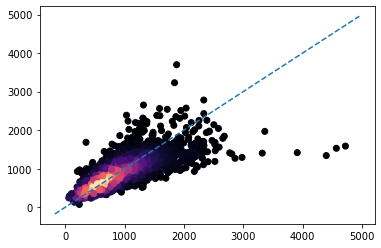

In [30]:
xy_bm = np.vstack([df_vor['bm_pred_lr_yr'], df_vor['Biomass_kg_ha']])
z_bm = gaussian_kde(xy_bm)(xy_bm)
plt.figure()
plt.scatter(df_vor['Biomass_kg_ha'], df_vor['bm_pred_lr_yr'], c=z_bm, cmap='magma')
abline(1, 0)

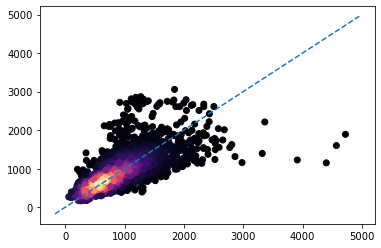

In [31]:
xy_bm = np.vstack([df_vor['bm_pred_rf_yr'], df_vor['Biomass_kg_ha']])
z_bm = gaussian_kde(xy_bm)(xy_bm)
plt.figure()
plt.scatter(df_vor['Biomass_kg_ha'], df_vor['bm_pred_rf_yr'], c=z_bm, cmap='magma')
abline(1, 0)

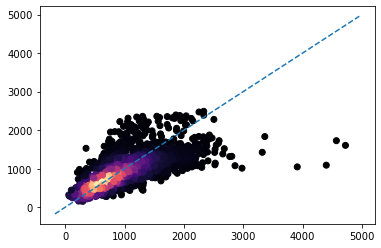

In [32]:
xy_bm = np.vstack([df_vor['bm_pred_mlp_yr'], df_vor['Biomass_kg_ha']])
z_bm = gaussian_kde(xy_bm)(xy_bm)
plt.figure()
plt.scatter(df_vor['Biomass_kg_ha'], df_vor['bm_pred_mlp_yr'], c=z_bm, cmap='magma')
abline(1, 0)

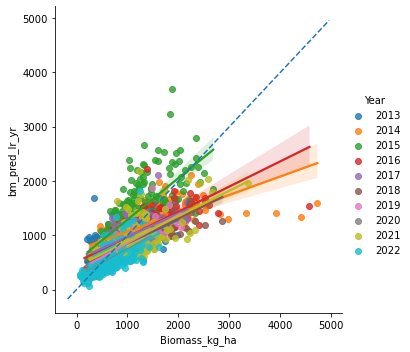

In [33]:
sns.lmplot(y='bm_pred_lr_yr', x='Biomass_kg_ha', hue='Year', data=df_vor)
abline(1, 0)

/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


                              OLS Regression Results                             
Dep. Variable:     np.log(Biomass_kg_ha)   R-squared:                       0.699
Model:                               OLS   Adj. R-squared:                  0.698
Method:                    Least Squares   F-statistic:                     530.6
Date:                   Fri, 07 Jul 2023   Prob (F-statistic):               0.00
Time:                           12:18:52   Log-Likelihood:                -486.75
No. Observations:                   2292   AIC:                             995.5
Df Residuals:                       2281   BIC:                             1059.
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       

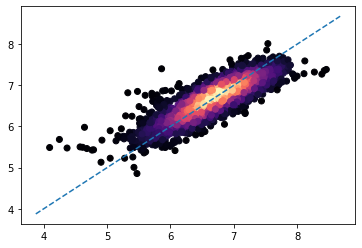

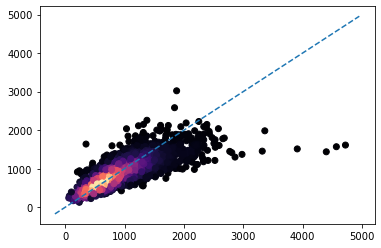

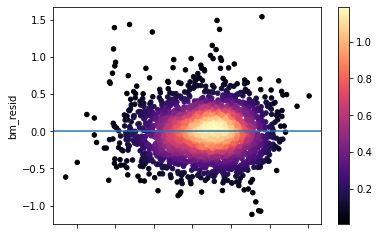

In [34]:
# fit the RF model to all data
all_x = df_vor[var_names_simp]
scaler.fit(all_x)
if scale_vars:
    all_x = scaler.transform(all_x)
    all_X = scaler.transform(all_X)
all_y = Y_var_all
rf_all = RandomForestRegressor(n_estimators=50, random_state=rand_st)
rf_all.fit(all_x, all_y)

# fit the linear model to all data
if wtd:
    lreg_all = smf.wls(formula=lr_form,
                       data=df_vor,
                       weights=1 / df_vor['Biomass_kg_ha']).fit()
else:
    lreg_all = smf.ols(formula=lr_form,
                       data=df_vor).fit()
print(lreg_all.summary())

if log_xfrm:
    df_vor['bm_pred_lr'] = lreg_all.predict(df_vor)
    xy_bm = np.vstack([df_vor['bm_pred_lr'], np.log(df_vor['Biomass_kg_ha'])])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    plt.figure()
    plt.scatter(np.log(df_vor['Biomass_kg_ha']), df_vor['bm_pred_lr'], c=z_bm, cmap='magma')
    abline(1, 0)

    xy_bm = np.vstack([np.exp(df_vor['bm_pred_lr']), df_vor['Biomass_kg_ha']])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    plt.figure()
    plt.scatter(df_vor['Biomass_kg_ha'], np.exp(df_vor['bm_pred_lr']), c=z_bm, cmap='magma')
    abline(1, 0)

    df_vor['bm_resid'] = df_vor['bm_pred_lr'] - np.log(df_vor['Biomass_kg_ha'])
    xy_bm_resid = np.vstack([df_vor['bm_resid'], df_vor['bm_pred_lr']])
    z_bm_resid = gaussian_kde(xy_bm_resid)(xy_bm_resid)
    df_vor[df_vor['Season'] != 'Weekly'].plot.scatter(x='bm_pred_lr', y='bm_resid', c=z_bm_resid, cmap='magma')
    plt.axhline(y=0)
else:
    df_vor['bm_pred_lr'] = lreg_all.predict(df_vor)
    xy_bm = np.vstack([df_vor['bm_pred_lr'], df_vor['Biomass_kg_ha']])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    plt.figure()
    plt.scatter(df_vor['Biomass_kg_ha'], df_vor['bm_pred_lr'], c=z_bm, cmap='magma')
    abline(1, 0)

    df_vor['bm_resid'] = df_vor['bm_pred_lr'] - df_vor['Biomass_kg_ha']
    xy_bm_resid = np.vstack([df_vor['bm_resid'], df_vor['bm_pred_lr']])
    z_bm_resid = gaussian_kde(xy_bm_resid)(xy_bm_resid)
    df_vor[df_vor['Season'] != 'Weekly'].plot.scatter(x='bm_pred_lr', y='bm_resid', c=z_bm_resid, cmap='magma')
    plt.axhline(y=0)

In [31]:
predictions_all_tmp

array([ 458.08,  294.48,  309.48,  303.7 ,  333.6 ,  448.12,  354.74,
        370.38,  562.18,  443.6 ,  459.58,  309.22,  309.08,  395.58,
        532.16,  399.36,  394.04,  361.46, 1184.86,  512.56,  469.54,
        484.14,  399.04,  459.2 ,  308.64,  415.28,  438.46,  344.96,
        412.96,  438.1 ,  542.48,  758.54,  770.78,  403.58,  544.12,
        502.88,  352.44,  500.76,  456.74,  470.94,  635.8 ,  507.74,
        570.78,  470.88,  311.02,  439.88,  428.6 ,  631.14,  427.16,
        584.58,  508.04,  427.88,  382.52,  327.86,  506.58,  415.12,
        539.54,  320.52,  340.22,  348.78,  435.08,  508.18,  500.56,
        356.64,  497.44,  590.58,  331.32,  444.24,  555.72,  433.54,
        429.  ,  519.08,  520.38,  356.24,  333.22,  517.24,  331.2 ,
        353.36,  333.58,  390.88,  354.62,  314.36,  377.3 ,  329.7 ,
        478.48,  438.8 ,  371.48,  449.7 ,  298.98,  314.32,  310.12,
        294.14,  353.5 ,  358.32,  321.18,  306.96,  374.28,  402.22,
        448.36,  491